# Long Short-Term Memory (LSTM)

## Data Preprocessing

### Import libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

### Import and filter dataset

In [2]:
df = pd.read_csv('daily_trans.csv', index_col='transaction_date', parse_dates=['transaction_date'])
df = df.loc['2022-05':]
df

,day_of_week,month,ALIPAY,WECHAT,VISA,MASTER,UNIONPAY,OCTOPUS,AMEX,AMEX (Aggregator),JCB,PAYME,merchant_count,net_amount
transaction_date,,,,,,,,,,,,,,
2022-05-01,7,5,3491335.02,667464.65,8.153024e+06,6.247270e+06,4.846662e+05,2671239.8,396210.16,0.00,16.82,0.0,7238,2.211123e+07
2022-05-02,1,5,3582294.50,585783.50,7.575955e+06,6.531089e+06,4.889271e+05,2940518.7,323477.78,0.00,0.00,0.0,7407,2.202805e+07
2022-05-03,2,5,2571202.69,492865.77,6.719553e+06,5.402191e+06,3.570804e+05,2375976.5,338648.54,0.00,0.00,0.0,7340,1.825752e+07
2022-05-04,3,5,2331203.24,430796.78,6.239774e+06,5.238412e+06,5.491507e+05,2264326.8,3966699.76,0.00,0.00,0.0,7425,2.102036e+07
2022-05-05,4,5,2361573.94,437927.50,7.153902e+06,5.785047e+06,5.541915e+05,2282149.1,404554.89,0.00,42.92,0.0,7595,1.897939e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-24,6,8,3899339.32,1907586.86,2.085039e+07,1.805861e+07,2.564426e+06,2310784.4,867818.39,1108853.76,76496.00,2659.0,12794,5.164697e+07
2024-08-25,7,8,3613893.87,1518140.29,1.638152e+07,1.358472e+07,1.906884e+06,2064651.0,558567.50,510522.12,11058.00,7052.2,11104,4.015700e+07
2024-08-26,1,8,3013554.03,1793075.87,1.342367e+07,1.211097e+07,1.893387e+06,1951462.8,659057.20,656771.28,51815.00,3800.0,11041,3.555756e+07


### Get day type feature

In [3]:
import json
with open('HK Public Holidays (2022-2024).json', encoding='utf-8-sig') as data_file:
    data = json.load(data_file)
holiday = pd.json_normalize(data['vcalendar'], 'vevent')[['dtstart', 'dtend', 'summary']]
holiday['dtstart'] = pd.to_datetime(holiday['dtstart'].map(lambda x: x[0]))
holiday['dtend'] = pd.to_datetime(holiday['dtend'].map(lambda x: x[0])) - pd.tseries.offsets.Day()
holiday['date_list'] = holiday.apply(lambda x: pd.date_range(x['dtstart'], x['dtend']).to_list(), axis=1)
holidays = np.array(holiday['date_list'].to_list()).ravel()

In [4]:
holidays

array([Timestamp('2022-01-01 00:00:00'), Timestamp('2022-02-01 00:00:00'),
       Timestamp('2022-02-02 00:00:00'), Timestamp('2022-02-03 00:00:00'),
       Timestamp('2022-04-05 00:00:00'), Timestamp('2022-04-15 00:00:00'),
       Timestamp('2022-04-16 00:00:00'), Timestamp('2022-04-18 00:00:00'),
       Timestamp('2022-05-02 00:00:00'), Timestamp('2022-05-09 00:00:00'),
       Timestamp('2022-06-03 00:00:00'), Timestamp('2022-07-01 00:00:00'),
       Timestamp('2022-09-12 00:00:00'), Timestamp('2022-10-01 00:00:00'),
       Timestamp('2022-10-04 00:00:00'), Timestamp('2022-12-26 00:00:00'),
       Timestamp('2022-12-27 00:00:00'), Timestamp('2023-01-02 00:00:00'),
       Timestamp('2023-01-23 00:00:00'), Timestamp('2023-01-24 00:00:00'),
       Timestamp('2023-01-25 00:00:00'), Timestamp('2023-04-05 00:00:00'),
       Timestamp('2023-04-07 00:00:00'), Timestamp('2023-04-08 00:00:00'),
       Timestamp('2023-04-10 00:00:00'), Timestamp('2023-05-01 00:00:00'),
       Timestamp('2023-05

In [5]:
df['day_type'] = np.where(df['day_of_week'] > 5, 'Weekend', 'Weekday')
df.loc[df.index.isin(holidays), 'day_type'] = 'Holiday'
df.loc[(df['day_of_week'] == 6) & ((df['day_type'].shift(1) == 'Holiday') | (df['day_type'].shift(-2) == 'Holiday')), 'day_type'] = 'Holiday'
df.loc[(df['day_of_week'] == 7) & ((df['day_type'].shift(2) == 'Holiday') | (df['day_type'].shift(-1) == 'Holiday')), 'day_type'] = 'Holiday'

### Decompose time series data into components as features

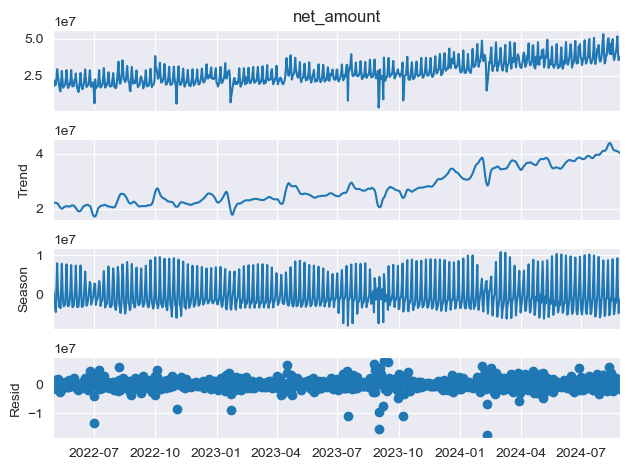

In [6]:
from statsmodels.tsa.seasonal import STL

res = STL(df['net_amount'], seasonal = 7).fit()

df.insert(df.columns.get_loc('net_amount'), 'net_amount_trend', res.trend)
df.insert(df.columns.get_loc('net_amount'), 'net_amount_seasonal', res.seasonal)
df.insert(df.columns.get_loc('net_amount'), 'net_amount_residual', res.resid)

res.plot()
plt.show()

### Encode categorical variables

#### Cyclic Encoding

In [7]:
def cyclic_encode(df, col, max_val):
    df.insert(df.columns.get_loc(col)+1, col +'_cos', np.cos(2 * np.pi *df[col]/max_val))
    df.insert(df.columns.get_loc(col)+1, col +'_sin', np.sin(2 * np.pi *df[col]/max_val))
    df.drop(columns=col, inplace=True)
    
cyclic_encode(df, 'month', 12)
cyclic_encode(df, 'day_of_week', 7)

#### One Hot Encoding

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [-1])], remainder = 'passthrough')
dataset = ct.fit_transform(df)


In [9]:
df

,day_of_week_sin,day_of_week_cos,month_sin,month_cos,ALIPAY,WECHAT,VISA,MASTER,UNIONPAY,OCTOPUS,AMEX,AMEX (Aggregator),JCB,PAYME,merchant_count,net_amount_trend,net_amount_seasonal,net_amount_residual,net_amount,day_type
transaction_date,,,,,,,,,,,,,,,,,,,,
2022-05-01,-2.449294e-16,1.000000,0.500000,-0.866025,3491335.02,667464.65,8.153024e+06,6.247270e+06,4.846662e+05,2671239.8,396210.16,0.00,16.82,0.0,7238,2.222113e+07,1.468917e+06,-1.578818e+06,2.211123e+07,Holiday
2022-05-02,7.818315e-01,0.623490,0.500000,-0.866025,3582294.50,585783.50,7.575955e+06,6.531089e+06,4.889271e+05,2940518.7,323477.78,0.00,0.00,0.0,7407,2.224530e+07,7.761856e+04,-2.948688e+05,2.202805e+07,Holiday
2022-05-03,9.749279e-01,-0.222521,0.500000,-0.866025,2571202.69,492865.77,6.719553e+06,5.402191e+06,3.570804e+05,2375976.5,338648.54,0.00,0.00,0.0,7340,2.224037e+07,-3.433558e+06,-5.492915e+05,1.825752e+07,Weekday
2022-05-04,4.338837e-01,-0.900969,0.500000,-0.866025,2331203.24,430796.78,6.239774e+06,5.238412e+06,5.491507e+05,2264326.8,3966699.76,0.00,0.00,0.0,7425,2.220878e+07,-2.647534e+06,1.459114e+06,2.102036e+07,Weekday
2022-05-05,-4.338837e-01,-0.900969,0.500000,-0.866025,2361573.94,437927.50,7.153902e+06,5.785047e+06,5.541915e+05,2282149.1,404554.89,0.00,42.92,0.0,7595,2.215548e+07,-4.579421e+06,1.403334e+06,1.897939e+07,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-24,-7.818315e-01,0.623490,-0.866025,-0.500000,3899339.32,1907586.86,2.085039e+07,1.805861e+07,2.564426e+06,2310784.4,867818.39,1108853.76,76496.00,2659.0,12794,4.095661e+07,9.248655e+06,1.441703e+06,5.164697e+07,Weekend
2024-08-25,-2.449294e-16,1.000000,-0.866025,-0.500000,3613893.87,1518140.29,1.638152e+07,1.358472e+07,1.906884e+06,2064651.0,558567.50,510522.12,11058.00,7052.2,11104,4.082689e+07,4.863188e+04,-7.185138e+05,4.015700e+07,Weekend
2024-08-26,7.818315e-01,0.623490,-0.866025,-0.500000,3013554.03,1793075.87,1.342367e+07,1.211097e+07,1.893387e+06,1951462.8,659057.20,656771.28,51815.00,3800.0,11041,4.067708e+07,-4.898276e+06,-2.212508e+05,3.555756e+07,Weekday


### Split dataset into training set and test set

In [10]:
training_set = dataset[:int(len(dataset)*0.9)].copy()
test_set = dataset[int(len(dataset)*0.9):].copy()

In [11]:
training_set

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.46891677e+06, -1.57881798e+06,  2.21112260e+07],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.76185623e+04, -2.94868756e+05,  2.20280461e+07],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -3.43355807e+06, -5.49291487e+05,  1.82575183e+07],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         1.02615217e+07, -8.79548310e+05,  4.41595137e+07],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         6.05872356e+05, -1.27671195e+05,  3.54682300e+07],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -4.80470312e+06, -6.80977228e+05,  2.97828050e+07]])

### Feature Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler

sc_y = MinMaxScaler(feature_range=(0,1))
sc_y.fit(training_set[:, -1:])

sc = MinMaxScaler(feature_range=(0,1))
training_set[:, 7:] = sc.fit_transform(training_set[:, 7:])
test_set[:, 7:] = sc.transform(test_set[:, 7:])

### Create sequences

In [13]:
timesteps = 30
n_future = 7 

X_train, y_train = [], []

for i in range(timesteps, len(training_set) - n_future +1):
    X_train.append(training_set[i - timesteps: i, :-1])
    y_train.append(training_set[i:i + n_future, -1])
    
X_train, y_train = np.array(X_train), np.array(y_train)   

In [14]:
test = np.concatenate([training_set[-timesteps:], test_set])
X_test, y_test = [],[]

for i in range(timesteps, len(test) - n_future +1):
    X_test.append(test[i - timesteps: i, :-1])
    y_test.append(test[i:i + n_future, -1])
    
X_test, y_test = np.array(X_test), np.array(y_test)   

## Build and train LSTM

https://www.tensorflow.org/api_docs/python/tf/keras

### Import libraries

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, LeakyReLU, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard


### Create custom loss function

In [16]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    # Get the dynamic batch size and sequence length
    batch_size = K.shape(y_true)[0]
    sequence_length = K.shape(y_true)[1]

    # Generate weights using tf.linspace
    weights = tf.linspace(1.0, 1.5, sequence_length)  # Adjust range as needed

    # Expand dimensions to match y_true and y_pred
    weights = tf.expand_dims(weights, axis=0)  # Shape becomes (1, sequence_length)
    weights = tf.tile(weights, [batch_size, 1])  # Shape becomes (batch_size, sequence_length)

    # Compute weighted MSE
    loss = K.mean(weights * K.square(y_true - y_pred), axis=-1)
    return loss

def custom_mse_with_penalty(y_true, y_pred):
    # Standard MSE loss
    mse = K.mean(K.square(y_true - y_pred), axis=-1)

    # Calculate the difference between consecutive time steps in predictions
    diff = y_pred[:, 1:] - y_pred[:, :-1]

    # Penalize small differences (encourage larger differences)
    penalty = K.mean(K.exp(-K.abs(diff)), axis=-1)  # Using exp(-|diff|) to penalize small changes

    # Combine the MSE with the penalty
    return mse + 0.01 * penalty  # Adjust the penalty weight as needed

### Design LSTM architecture (Add input, hidden, output layers)

In [17]:
regressor = Sequential()
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

regressor.add(LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.0001)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.0001)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.0001)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100, return_sequences=False, kernel_regularizer=l2(0.0001)))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=n_future))
regressor.add(LeakyReLU(negative_slope=0.2))

### Visualize model architecture

In [18]:
regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        48,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           707 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,707 (1.11 MB)

 Trainable params: 290,707 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

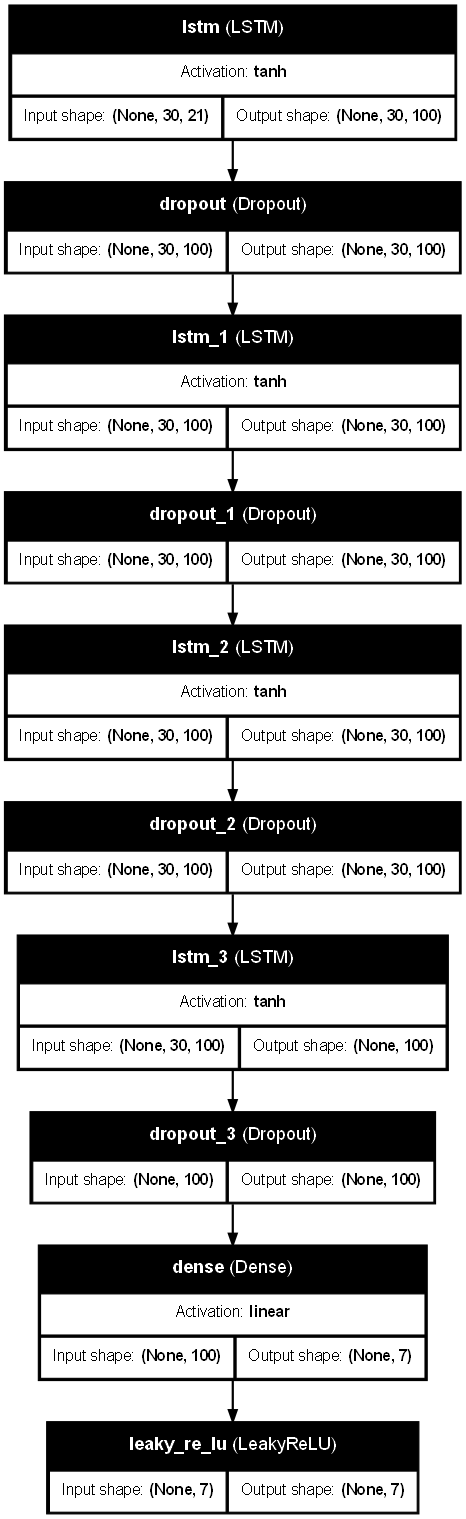

In [19]:
keras.utils.plot_model(regressor, show_shapes=True, show_layer_names=True, dpi=80, show_layer_activations=True)


### Compile LSTM

In [20]:
regressor.compile(optimizer=Adam(), loss=weighted_mse)

### Add callbacks

In [21]:
es = EarlyStopping(monitor='val_loss', min_delta= 1e-10, patience=10, verbose=1, mode='min', restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7)
mcp = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', verbose=1, save_best_only=True)
tb = TensorBoard('logs')

### Train LSTM on training set

In [22]:
epochs =100
history = regressor.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=1, callbacks=[es, rlr, mcp, tb], validation_split=0.2, shuffle=True)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1508
Epoch 1: val_loss improved from inf to 0.11396, saving model to best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.1486 - val_loss: 0.1140 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0681
Epoch 2: val_loss improved from 0.11396 to 0.07658, saving model to best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0680 - val_loss: 0.0766 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0588
Epoch 3: val_loss improved from 0.07658 to 0.05911, saving model to best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0587 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0515
Epoch 4: val_loss improved from 0.05911 to 0.05338, saving model to best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0515 - val_loss: 0.0534 - learning_rate: 0.0010
Ep

### Visualize training history

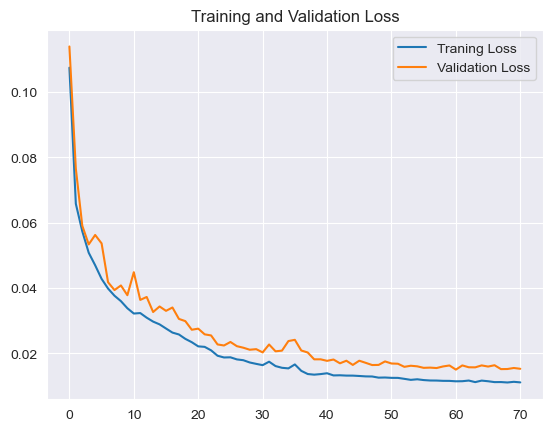

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.plot(epochs_range, loss, label= 'Traning Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict

### Load saved model

In [25]:
best_model = keras.models.load_model('best_model.keras', custom_objects={'weighted_mse': weighted_mse})

### Visualize predictions on training set

In [26]:
y_pred = regressor.predict(X_train)
plot_pred = np.array([e for i, e in enumerate(y_pred) if i % n_future == 0]).ravel()
plot_true = np.array([e for i, e in enumerate(y_train) if i % n_future == 0]).ravel()

plot_pred = sc_y.inverse_transform(plot_pred.reshape(-1, 1)).ravel()
plot_true = sc_y.inverse_transform(plot_true.reshape(-1, 1)).ravel()

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


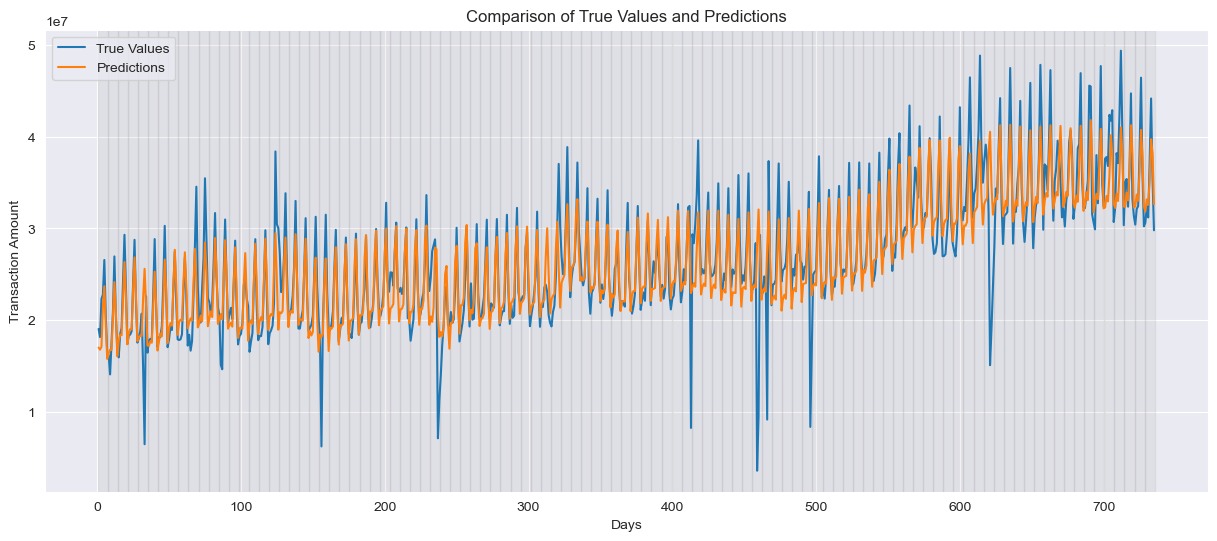

In [27]:
days = np.arange(1, len(plot_pred) + 1)

plt.figure(figsize=(15, 6))
plt.plot(days, plot_true, label='True Values')
plt.plot(days, plot_pred, label='Predictions')

# Highlight each 7-day interval
for i in range(0, len(days), 7):
    plt.axvspan(i+0.5, i+7.5, color='gray', alpha=0.1)  # Shade each 7-day block

plt.title('Comparison of True Values and Predictions')
plt.xlabel('Days')
plt.ylabel('Transaction Amount')
# plt.xlim(500, 700)
plt.legend()
plt.show()

### Evaluate and visualize predictions on test set

In [28]:
regressor.evaluate(X_test, y_test, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0276


{'loss': 0.03269604593515396}

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


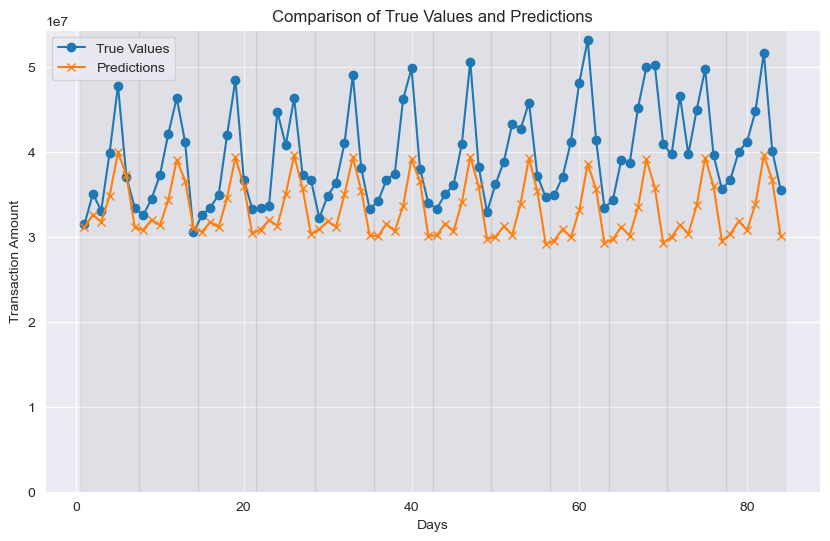

In [29]:
y_pred = regressor.predict(X_test)
plot_pred = np.array([e for i, e in enumerate(y_pred) if i % n_future == 0]).ravel()
plot_true = np.array([e for i, e in enumerate(y_test) if i % n_future == 0]).ravel()

plot_pred = sc_y.inverse_transform(plot_pred.reshape(-1, 1)).ravel()
plot_true = sc_y.inverse_transform(plot_true.reshape(-1, 1)).ravel()

# plot_pred = np.expm1(plot_pred)
# plot_true = np.expm1(plot_true)

days = np.arange(1, len(plot_pred) + 1)

plt.figure(figsize=(10, 6))
plt.plot(days, plot_true, label='True Values', marker='o')
plt.plot(days, plot_pred, label='Predictions', marker='x')

# Highlight each 7-day interval
for i in range(0, len(days), 7):
    plt.axvspan(i+0.5, i+7.5, color='gray', alpha=0.1)  # Shade each 7-day block

plt.title('Comparison of True Values and Predictions')
plt.xlabel('Days')
plt.ylabel('Transaction Amount')
plt.ylim(0,)
plt.legend()
plt.show()